
image 1/1 /Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Datasets/schema_food.png: 640x608 1 broccoli, 1 chicken duck, 1 lemon, 262.3ms
Speed: 5.4ms preprocess, 262.3ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 640)


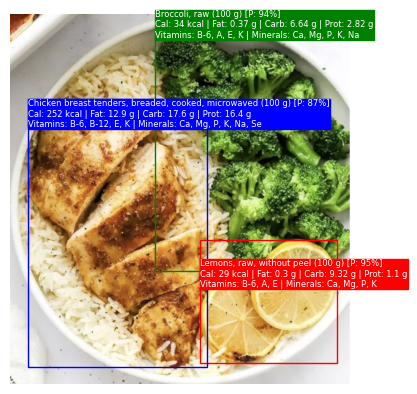

In [1]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import difflib
from collections import defaultdict
from itertools import cycle
import pandas as pd
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

def predict_yolov8(path_checkpoint, best_pt, path_img):
    """
    Uses the pre-trained YOLOv8 model to predict a new picture.

    Args:
        path_checkpoint (str): Path of the checkpoint for the pre-trained YOLOv8 for a instance segmentation task.
        best_pt (str): Name of the best checkpoint file.
        path_img (str): Path of the predicted picture.

    Returns:
        results (list): A list containing all nutritional info extracted from the website.
    """  
    model = YOLO(path_checkpoint+best_pt)  # load a pretrained model (recommended for training)
    device = torch.device("mps")
    model.to(device)
    results = model(path_img)
    return results

def detected_labels(results_yolo):
    """
    Extracts the labels from the YOLOv8 results.

    Args:
        results (list): A list containing all nutritional info extracted from the website.

    Returns:
        detected_labels (list): A list containing all YOLOv8 detected labels.
    """  
    results_object = results_yolo[0]
    detected_classes = results_object.boxes.cls
    # detected_labels = [results_object.names[int(i)] for i in detected_classes]
    detected_labels = list(dict.fromkeys([results_object.names[int(i)] for i in detected_classes]))
    return detected_labels

def get_corresponding_labels(yolo_labels, correspondence_dict):
    """
    This function iterates over the labels received from the YOLOv8 model, and 
    checks those values against the dictionary of correspondence values. 

    Args:
        yolo_labels (list): List of labels obtained from YOLOv8 model
        correspondence_dict (dict): Dictionary mapping YOLO labels to corresponding labels

    Returns:
        list: List of corresponding labels as per the dictionary.
    """
    labels_correspondence = [correspondence_dict[label] for label in yolo_labels if label in correspondence_dict]
    return labels_correspondence

def load_fdc_data(filename):
    # Load the FDC data
    df = pd.read_csv(filename)
    
    return df

def search_food(detected_labels, fdc_df):
    """
    Searches the given food in the FDC dataframe, returning the corresponding urls.

    Args:
        detected_labels (list): A list containing all YOLOv8 detected labels.
        fdc_df (DataFrame): The FDC data.

    Returns:
        food_urls (dict): A dictionary containing all urls given the food names.
    """  
    food_urls = {}
    for food in detected_labels:
        # Find the rows in the dataframe where the description contains the food label
        matches = fdc_df[fdc_df['description'].str.contains(food)]
        if not matches.empty:
            # If there are any matches, take the first one
            fdc_id = matches.iloc[0]['fdc_id']
            # Construct the URL using the FDC ID
            food_urls[food] = f"https://fdc.nal.usda.gov/fdc-app.html#/food-details/{fdc_id}/nutrients"
            
    return food_urls

def get_nutritional_info(url):
    """
    Extracts the nutritional info from a given website using Selenium.

    Args:
        url (str): Website URL that gives the nutritional info.

    Returns:
        nutrition_info (dict): A dictionary containing all nutritional info extracted from the website.
    """  

    options = Options()
    options.add_argument('-headless')
    driver = webdriver.Firefox(options=options)
    driver.get(url)
    
    food_name = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "//h1"))).text
    if food_name == 'FoodData Central Search Results':
        food_name = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "(//h1)[2]"))).text
        
    nutrition_info = {food_name: {}}

    # Get serving size
    nutrition_info[food_name]['Serving Size'] = '100 g'

    # Get required nutrients
    required_nutrients = {
        'Energy': 'Calories', 
        'Carbohydrate, by difference': 'Carb', 
        'Protein': 'Protein', 
        'Total lipid (fat)': 'Fat'
    }

    # Get nutrients
    nutrients = driver.find_elements('xpath','//span[@name="finalFoodNutrientName"]')
    values = driver.find_elements('xpath','//span[@name="finalFoodNutrientValue"]')
    units = driver.find_elements('xpath','//span[@name="finalFoodNutrientStandardUnit"]')

    for nutrient, value, unit in zip(nutrients, values, units):
        if nutrient.text in required_nutrients and required_nutrients[nutrient.text] != 'Calories':
            nutrition_info[food_name][required_nutrients[nutrient.text]] = value.text
        elif nutrient.text == 'Energy' and unit.text == 'kcal':
            nutrition_info[food_name]['Calories'] = f"{value.text} {unit.text}"

    # List of minerals and vitamins
    minerals_list = ['Calcium, Ca', 'Iron, Fe', 'Magnesium, Mg', 'Phosphorus, P', 'Potassium, K', 'Sodium, Na', 'Zinc, Zn', 'Copper, Cu', 'Manganese, Mn', 'Selenium, Se', 'Fluoride, F']
    vitamins_list = ['Vitamin B-6', 'Vitamin B-12', 'Vitamin A, RAE', 'Vitamin E (alpha-tocopherol)', 'Vitamin D (D2 + D3)', 'Vitamin K (phylloquinone)']

    minerals = []
    vitamins = []

    for nutrient, value in zip(nutrients, values):
        if nutrient.text in minerals_list and float(value.text) > 3:
            minerals.append(nutrient.text.split(", ")[1])  # Extracting mineral abbreviation
        if nutrient.text in vitamins_list and float(value.text) > 0:
            if nutrient.text == 'Vitamin A, RAE':
                vitamins.append('A')
            else:
                vitamin_name = nutrient.text.split(" ")[1]  # Extracting vitamin name
                vitamins.append(vitamin_name)

    if minerals:
        nutrition_info[food_name]['Minerals'] = ', '.join(minerals)
    if vitamins:
        nutrition_info[food_name]['Vitamins'] = ', '.join(vitamins)

    driver.quit()

    return nutrition_info

def add_qualification_info(nutrition_info, thresholds):
    """
    Compares the nutrition values with a list of thresholds in order to have a qualitative outcome to show to the customer.
    **************** still ongoing, not finished ****************

    Args:
        nutrition_info (list): A list containing all nutritional info extracted from the website.
        thresholds (list): A list containing suggested values for nutrition parameters.

    Returns:
        qualifications (list): A list of the qualitative version of the nutritional values.
    """ 
    qualifications = []

    if float(nutrition_info['Protein'][:-1]) > thresholds['protein']:
        qualifications.append("Good Amount of Protein")

    if float(nutrition_info['Calories'][:-1]) > thresholds['calories']:
        qualifications.append("High Amount of Calories")

    return qualifications

def find_best_match(label, nutrition_keys):
    """
    Compares the nutrition label names from a given nutritional website with the YOLOv8 predicted labels.

    Args:
        label (list): A list containing the labels predicted by YOLOv8.
        nutrition_keys (list): A list containing the labels found on the website.

    Returns:
        best_match (list): A list of the matching labels.
    """  
    best_match_ratio = 0
    best_match = ""
    
    for key in nutrition_keys:
        # sm = difflib.SequenceMatcher(None, label.lower(), key.lower())
        sm = difflib.SequenceMatcher(None, label.lower(), key.split(',')[0].lower())
        match_ratio = sm.ratio()
        # print(f'between {label.lower()} and {key.lower()}, match ratio: {match_ratio}')
        
        if match_ratio > best_match_ratio:
            best_match_ratio = match_ratio
            best_match = key
            
    return best_match

def LabeledPicture(path_img, results, nutrition_info, labels_correspondence):
    """
    Aggregates nutritional info on the predicted picture, together with the boundary boxes.

    Args:
        path_img (str): Path of the predicted picture.
        results (list): A list containing all predicted results from YOLOv8.
        nutrition_info (dict): A dictionary containing all nutritional info extracted from the website.
        labels_correspondence (list): A list containing all correspondence labels (detected vs website).

    Returns:
        plt (Figure): A matplotlib figure of the food plate with the boundary boxes and nutritional info.
    """
    results_object = results[0]

    # Load image
    img = cv2.imread(path_img)

    # Convert BGR image to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_rgb)

    # Define color dict
    colors = cycle(['red', 'green', 'blue', 'magenta', 'cyan'])

    # Find the highest and lowest y-coordinates among all bounding boxes
    y_values = [box.xyxy[0][1].item() for box in results_object.boxes]
    highest_y = round(max(y_values))
    lowest_y = round(min(y_values))

    # Create a dictionary to map each class_id to a color
    color_dict = defaultdict(lambda: next(colors))
    
    # Remove duplicated boxes
    boxes = list(results[0].boxes)
    nms_threshold = 0.40  # adjust this value to your needs

    for i, box in enumerate(boxes):
        for j in range(i+1, len(boxes)):
            box2 = boxes[j]
            cords = box.xyxy[0].tolist()
            cords = [round(x) for x in cords]
            cords2 = box2.xyxy[0].tolist()
            cords2 = [round(x) for x in cords2]
            xA = max(cords[0], cords2[0])
            yA = max(cords[1], cords2[1])
            xB = min(cords[2], cords2[2])
            yB = min(cords[3], cords2[3])
            
            # compute the area of intersection rectangle
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
            
            # compute the area of both the prediction and ground-truth rectangles
            boxAArea = (cords[2] - cords[0] + 1) * (cords[3] - cords[1] + 1)
            boxBArea = (cords2[2] - cords2[0] + 1) * (cords2[3] - cords2[1] + 1)
            
            # compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
            iou = interArea / float(boxAArea + boxBArea - interArea)
            # check if the IoU of the two boxes is above a threshold
            if iou > nms_threshold:
                # check if the boxes belong to the same class
                if results[0].names[box.cls[0].item()] == results[0].names[box2.cls[0].item()]:
                    # discard the box with lower confidence score
                    if box.conf[0].item() < box2.conf[0].item():
                        boxes.remove(box)
                        break
                    else:
                        boxes.remove(box2)
                        break   
    # print(boxes)
    # For each detected object
    for box in boxes:
        class_id = results_object.names[box.cls[0].item()]
        cords = box.xyxy[0].tolist()
        cords = [round(x) for x in cords]
        conf = round(box.conf[0].item() * 100)

        # Find the best match for class_id in the nutrition_keys
        best_match = find_best_match(class_id, list(nutrition_info.keys()))

        # Create a Rectangle patch
        rect = patches.Rectangle((cords[0], cords[1]), cords[2]-cords[0], cords[3]-cords[1], linewidth=1, edgecolor=color_dict[class_id], facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Prepare text
        text = f"{best_match} ({nutrition_info[best_match].get('Serving Size', 'N/A')}) [P: {conf}%]\n"
        text += f"Cal: {nutrition_info[best_match].get('Calories', 'N/A')} | Fat: {nutrition_info[best_match].get('Fat', 'N/A')} g | Carb: {nutrition_info[best_match].get('Carb', 'N/A')} g | Prot: {nutrition_info[best_match].get('Protein', 'N/A')} g\n"

        # Add vitamins and minerals if they exist and are not 0
        vitamins = [f"{key}: {value}" for key, value in nutrition_info[best_match].items() if key.startswith('Vitamin') and value not in ['0', '-']]
        minerals = [f"{key}: {value}" for key, value in nutrition_info[best_match].items() if key.startswith('Mineral') and value not in ['0', '-']]

        nutrition_elements = []
        if vitamins:
            nutrition_elements.append(', '.join(vitamins))
        if minerals:
            nutrition_elements.append(', '.join(minerals))

        if nutrition_elements:
            text += ' | '.join(nutrition_elements)

        # Determine y-position for the label
        if cords[1] == highest_y:
            y_position = cords[1] + 70
        elif cords[1] == lowest_y:
            y_position = cords[1] - 70
        else:
            y_position = cords[1]
        
        # Place the label
        plt.text(x=cords[0], y=y_position, s=text, color='white', verticalalignment='top',
                 bbox={'color': color_dict[class_id], 'pad': 0}, fontsize=6)

    plt.axis('off')
    return plt

def main():
    """
    Main function that orchestrates the entire program execution.

    The function should include all necessary steps to predict a picture in a pre-trained YOLOv8 model (instance segmentation task),
    extract the labels and coordinates, send this info to beautifulsoup4, which takes those labels and use in a website to
    extract nutritional info. Finally, the picture is shown, together with the boundary boxes and the nutritional info.
    """
    # thresholds = {
    #     'protein': 10,
    #     'calories': 200
    # }

    path_checkpoint = "/Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Codes/Iterations_YOLOv8/20230412_yolov8s-seg_30epochs/runs/segment/train/weights/"
    best_yolo_model = 'best.pt'
    img_path = "/Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Datasets/schema_food.png"
    fdc_food_file = "/Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Codes/FoodData_Central_sr_legacy_food_csv_2018-04/food.csv"
    
    correspondence_dict = {'apple': 'Apples, raw, golden delicious, with skin', 'asparagus': 'Asparagus, cooked, boiled, drained', 'avocado': 'Avocados, raw, all commercial varieties', \
                            'banana': 'Bananas, raw', 'bread': 'Bread, white wheat', 'broccoli': 'Broccoli, raw', 'cabbage': 'Cabbage, raw', 'cake': 'Cake, sponge, commercially prepared',\
                            'carrot': 'Carrots, raw', 'cashew': 'Nuts, cashew nuts, raw', 'cauliflower': 'Cauliflower, raw', 'chicken duck': 'Chicken breast tenders, breaded, cooked, microwaved',\
                            'chocolate': 'Candies, SYMPHONY Milk Chocolate Bar', 'corn': 'Corn, sweet, yellow, cooked, boiled, drained, with salt', 'cucumber': 'Cucumber, with peel, raw',\
                            'egg': 'Egg, whole, cooked, omelet', 'eggplant': 'Eggplant, cooked, boiled, drained, with salt', 'fish': 'Fish, cod, Atlantic, cooked, dry heat', 'french fries': 'Potatoes,\
                            french fried, all types, salt added in processing, frozen, home-prepared, oven heated', 'garlic': 'Garlic, raw', 'hamburg': 'Fast foods, hamburger', 'lemon': 'Lemons, raw, without peel',\
                            'lettuce': 'Lettuce, green leaf, raw', 'noodles': 'Rice noodles, cooked', 'olives': 'Olives, pickled, canned or bottled, green', 'onion': 'Onions, yellow, sauteed', 'orange': 'Oranges, raw, with peel',\
                            'pasta': 'Pasta, cooked, enriched, without added salt', 'peanut': 'Peanuts, all types, raw', 'pepper': 'Peppers, sweet, red, sauteed', 'pie': 'Pie, fried pies, fruit', 'pineapple': 'Pineapple, raw, all varieties',\
                            'pizza': 'Pizza, cheese topping, thin crust, frozen, cooked', 'popcorn': 'Snacks, popcorn, air-popped', 'pork': 'Pork, fresh, shoulder, whole, separable lean and fat, cooked, roasted',\
                            'potato': 'Potatoes, mashed, ready-to-eat', 'pumpkin': 'Pumpkin, cooked, boiled, drained, without salt', 'rice': 'Rice, white, long-grain, regular, enriched, cooked', 'salad': 'Lettuce, green leaf, raw',\
                            'sauce': 'Sauce, pesto, ready-to-serve, shelf stable', 'sausage': 'Sausage, turkey, fresh, cooked', 'shiitake': 'Mushrooms, shiitake, cooked, with salt', 'shrimp': 'Crustaceans, shrimp, cooked',\
                            'soup': 'Soup, vegetable broth, ready to serve', 'soy': 'Soybeans, green, raw', 'steak': 'Restaurant, family style, sirloin steak', 'tofu': 'Tofu, raw, firm, prepared with calcium sulfate',\
                            'tomato': 'Tomatoes, orange, raw', 'walnut': 'Nuts, walnuts, english', 'wine': 'Alcoholic Beverage, wine, table, red, Cabernet Sauvignon'}
    
    results = predict_yolov8(path_checkpoint, best_yolo_model, img_path)
                            
    food_names = detected_labels(results)
    # print(food_names)
    labels_correspondence = get_corresponding_labels(food_names, correspondence_dict)
    
    # Load FDC Food database
    fdc_df = load_fdc_data(fdc_food_file)
    
    # Search for each food name
    food_urls = search_food(labels_correspondence, fdc_df)
    
    nutrition_info = {}
    for food, url in food_urls.items():
        nutrition_info.update(get_nutritional_info(url))
         
    img = LabeledPicture(img_path, results, nutrition_info, labels_correspondence)
    img.show()

if __name__ == "__main__":
    main()

In [3]:
import pandas as pd

# Read the Excel file
path_to_file = "/Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Datasets/labels_foodv18.xlsx"
df = pd.read_excel(path_to_file, sheet_name='Correspondence') 

# Drop rows where 'correspondence' is NaN
df = df[df['correspondence'].notna()]

# Create the mapping dictionary
mapping_dict = df.set_index('label')['correspondence'].to_dict()

print(mapping_dict)

{'apple': 'Apples, raw, golden delicious, with skin', 'asparagus': 'Asparagus, cooked, boiled, drained', 'avocado': 'Avocados, raw, all commercial varieties', 'banana': 'Bananas, raw', 'bread': 'Bread, white wheat', 'broccoli': 'Broccoli, raw', 'cabbage': 'Cabbage, raw', 'cake': 'Cake, sponge, commercially prepared', 'carrot': 'Carrots, raw', 'cashew': 'Nuts, cashew nuts, raw', 'cauliflower': 'Cauliflower, raw', 'chicken duck': 'Chicken breast tenders, breaded, cooked, microwaved', 'chocolate': 'Candies, SYMPHONY Milk Chocolate Bar', 'corn': 'Corn, sweet, yellow, cooked, boiled, drained, with salt', 'cucumber': 'Cucumber, with peel, raw', 'egg': 'Egg, whole, cooked, omelet', 'eggplant': 'Eggplant, cooked, boiled, drained, with salt', 'fish': 'Fish, cod, Atlantic, cooked, dry heat', 'french fries': 'Potatoes, french fried, all types, salt added in processing, frozen, home-prepared, oven heated', 'garlic': 'Garlic, raw', 'hamburg': 'Fast foods, hamburger', 'lemon': 'Lemons, raw, without 

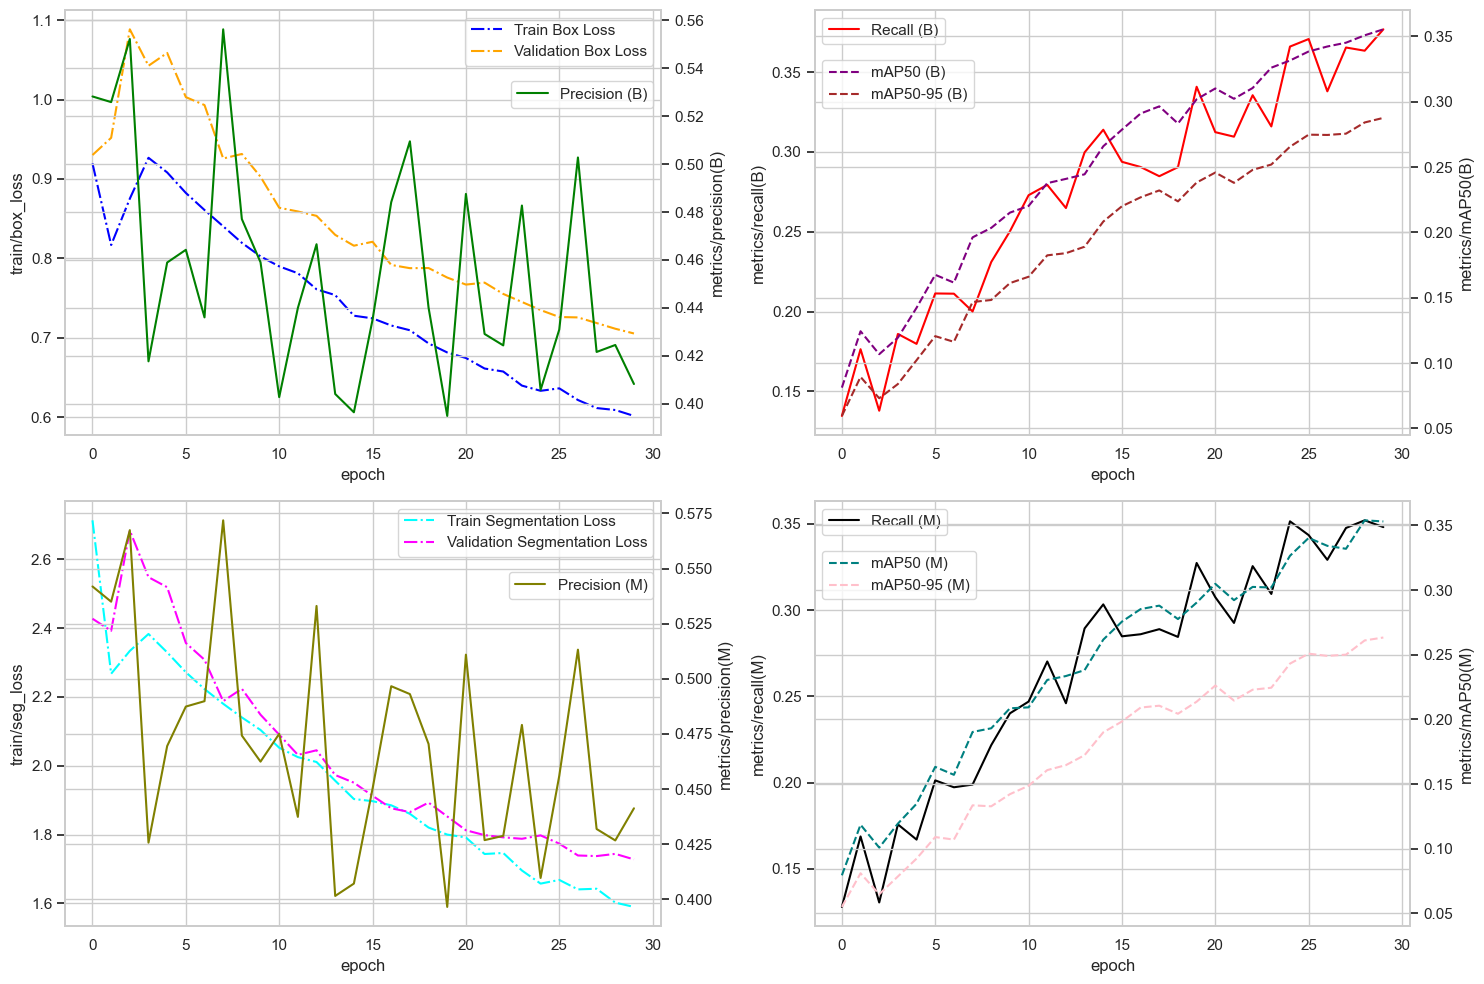

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a pandas dataframe df with the necessary columns
df_chart = pd.read_csv('/Users/marcelosouza/Documents/MBA_USP/5_TCC/Insulin_Suggester/Codes/Iterations_YOLOv8/20230412_yolov8s-seg_30epochs/runs/segment/train/results.csv')
df_chart.columns = df_chart.columns.str.strip()

# Set the style of seaborn to a nice one
sns.set(style='whitegrid')

# Create a figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train/box_loss and val/box_loss plot with Precision (B) on the right y-axis
sns.lineplot(data=df_chart, x='epoch', y='train/box_loss', ax=axes[0, 0], color='blue', label='Train Box Loss', linestyle='-.')
sns.lineplot(data=df_chart, x='epoch', y='val/box_loss', ax=axes[0, 0], color='orange', label='Validation Box Loss', linestyle='-.')
axes00 = axes[0, 0].twinx()
sns.lineplot(data=df_chart, x='epoch', y='metrics/precision(B)', ax=axes00, color='green', label='Precision (B)')

# Metrics/recall(B) plot with metrics/mAP50(B) and metrics/mAP50-95(B) on the right y-axis
sns.lineplot(data=df_chart, x='epoch', y='metrics/recall(B)', ax=axes[0, 1], color='red', label='Recall (B)')
axes01 = axes[0, 1].twinx()
sns.lineplot(data=df_chart, x='epoch', y='metrics/mAP50(B)', ax=axes01, color='purple', label='mAP50 (B)', linestyle='--')
sns.lineplot(data=df_chart, x='epoch', y='metrics/mAP50-95(B)', ax=axes01, color='brown', label='mAP50-95 (B)', linestyle='--')

# Train/seg_loss and val/seg_loss plot with Precision (M) on the right y-axis
sns.lineplot(data=df_chart, x='epoch', y='train/seg_loss', ax=axes[1, 0], color='cyan', label='Train Segmentation Loss', linestyle='-.')
sns.lineplot(data=df_chart, x='epoch', y='val/seg_loss', ax=axes[1, 0], color='magenta', label='Validation Segmentation Loss', linestyle='-.')
axes10 = axes[1, 0].twinx()
sns.lineplot(data=df_chart, x='epoch', y='metrics/precision(M)', ax=axes10, color='olive', label='Precision (M)')

# Metrics/recall(M) plot with metrics/mAP50(M) and metrics/mAP50-95(M) on the right y-axis
sns.lineplot(data=df_chart, x='epoch', y='metrics/recall(M)', ax=axes[1, 1], color='black', label='Recall (M)')
axes11 = axes[1, 1].twinx()
sns.lineplot(data=df_chart, x='epoch', y='metrics/mAP50(M)', ax=axes11, color='teal', label='mAP50 (M)', linestyle='--')
sns.lineplot(data=df_chart, x='epoch', y='metrics/mAP50-95(M)', ax=axes11, color='pink', label='mAP50-95 (M)', linestyle='--')

# Setting legends for each plot
axes[0, 0].legend(loc='upper right')
axes00.legend(loc='upper right', bbox_to_anchor=(1, 0.85))
axes[0, 1].legend(loc='upper left')
axes01.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
axes[1, 0].legend(loc='upper right')
axes10.legend(loc='upper right', bbox_to_anchor=(1, 0.85))
axes[1, 1].legend(loc='upper left')
axes11.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

# Displaying the plot
plt.tight_layout()
plt.show()
